import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Import data into tensorflow dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=4
EPOCHS=50

## '''img_height, img_width = 32,32
dataset = tf.keras.preprocessing.image_dataset_from_directory("datasets",
    seed=123,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=BATCH_SIZE)

In [24]:
img_height, img_width = 32,32
dataset = tf.keras.preprocessing.image_dataset_from_directory("datasets",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 4188 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 32, 32, 3)
[1 3 3 0 0 0 3 2 2 2 0 1 3 3 1 0 3 1 1 0 1 3 3 2 3 3 0 0 1 3 2 0]


# Visualize some of the images from our dataset

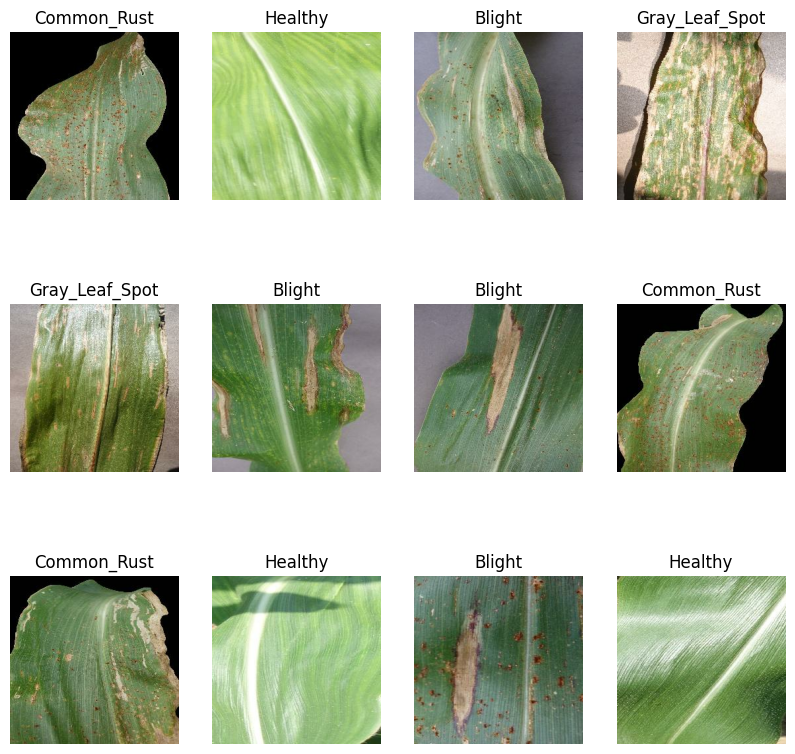

In [25]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

131

# Now we have total 131 datasets from here we are going to take:

# 80% ==> training
# 20% ==> 10% validation , 10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

104.80000000000001

In [11]:
train_ds = dataset.take(104)
len(train_ds)

104

# Going to skip first 104 datasets for next process like validation and testing.

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

77

In [13]:
val_size=0.1
len(dataset)*val_size

13.100000000000001

In [14]:
val_ds = test_ds.take(15)
len(val_ds)

15

In [15]:
test_ds = test_ds.skip(15)
len(test_ds)

62

# Function to take tensorflow dataset for split, train and validate.

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

104

In [14]:
len(val_ds)

13

In [15]:
len(test_ds)

14

# Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model
Creating a Layer for Resizing and Normalization

In [22]:
def random_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def random_rotate(image):
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image

# Applying Data Augmentation to Train Dataset

In [6]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


NameError: name 'IMAGE_SIZE' is not defined

In [26]:
from tensorflow.keras import layers

IMAGE_SIZE = 256

# Define resizing and rescaling pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to target size
    layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]
])


In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (4,4), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (32, 256, 256, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (32, 253, 253, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 126, 126, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (32, 124, 124, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,996 (722.64 KB)

 Trainable params: 184,996 (722.64 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    # Add more layers...
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

In [32]:
train_ds = train_ds.map(lambda x, y: (x[..., :3], y))
val_ds = val_ds.map(lambda x, y: (x[..., :3], y))

In [33]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
for x, y in train_ds.take(1):
    print(x.shape)  # Should be (batch_size, 256, 256, 3)
    print(y.shape)  # Should be (batch_size,) for sparse labels, or (batch_size, 4) for one-hot labels

(32, 256, 256, 3)
(32,)


In [36]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.5305 - loss: 20228.3105 - val_accuracy: 0.8678 - val_loss: 23.9717
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.9009 - loss: 20.6514 - val_accuracy: 0.9231 - val_loss: 7.5782
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9473 - loss: 5.5351 - val_accuracy: 0.9399 - val_loss: 5.9728
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9806 - loss: 2.2804 - val_accuracy: 0.9399 - val_loss: 4.9777
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9852 - loss: 1.8489 - val_accuracy: 0.9423 - val_loss: 4.4022
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9840 - loss: 1.5695 - val_accuracy: 0.9543 - val_loss: 5.3675
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9894 - loss: 0.9377 - val_accuracy: 0.9543 - val_loss: 3.0638
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9937 - loss: 0.5307 - va

In [37]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.9550 - loss: 2.9675


In [38]:
scores

[1.8270071744918823, 0.9642857313156128]

In [39]:

history

In [40]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 104}

In [41]:

type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

50

In [43]:

history.history['loss'][:5] # show loss for first 5 epochs

[6693.42236328125,
 21.280078887939453,
 5.2028045654296875,
 2.83186674118042,
 2.362096071243286]

In [44]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

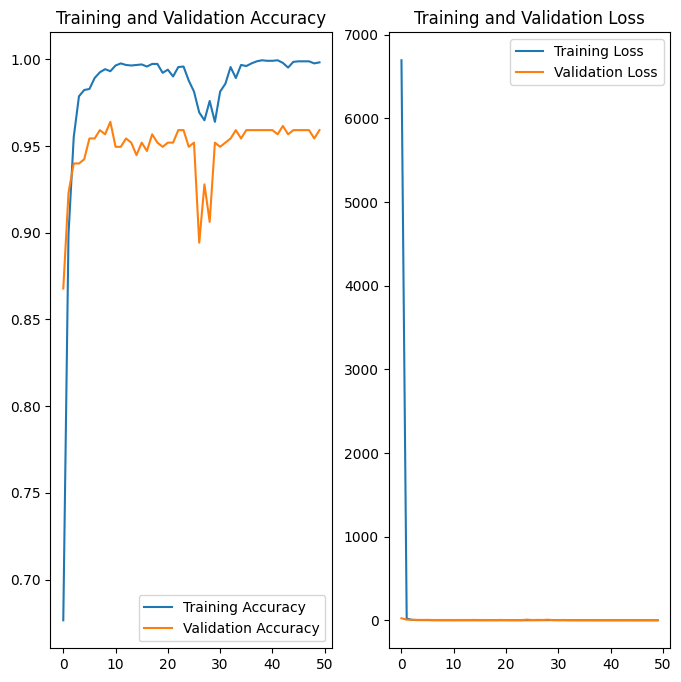

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run Prediction on a sample image

first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
predicted label: Common_Rust


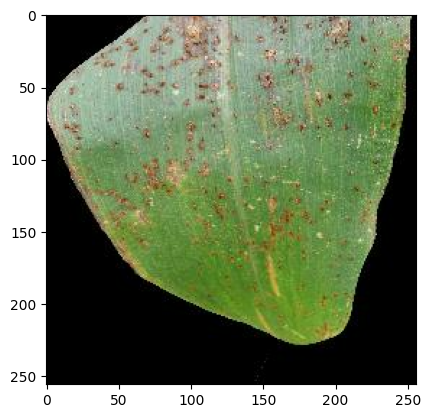

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Writing a Function for Interface

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now Running few more samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


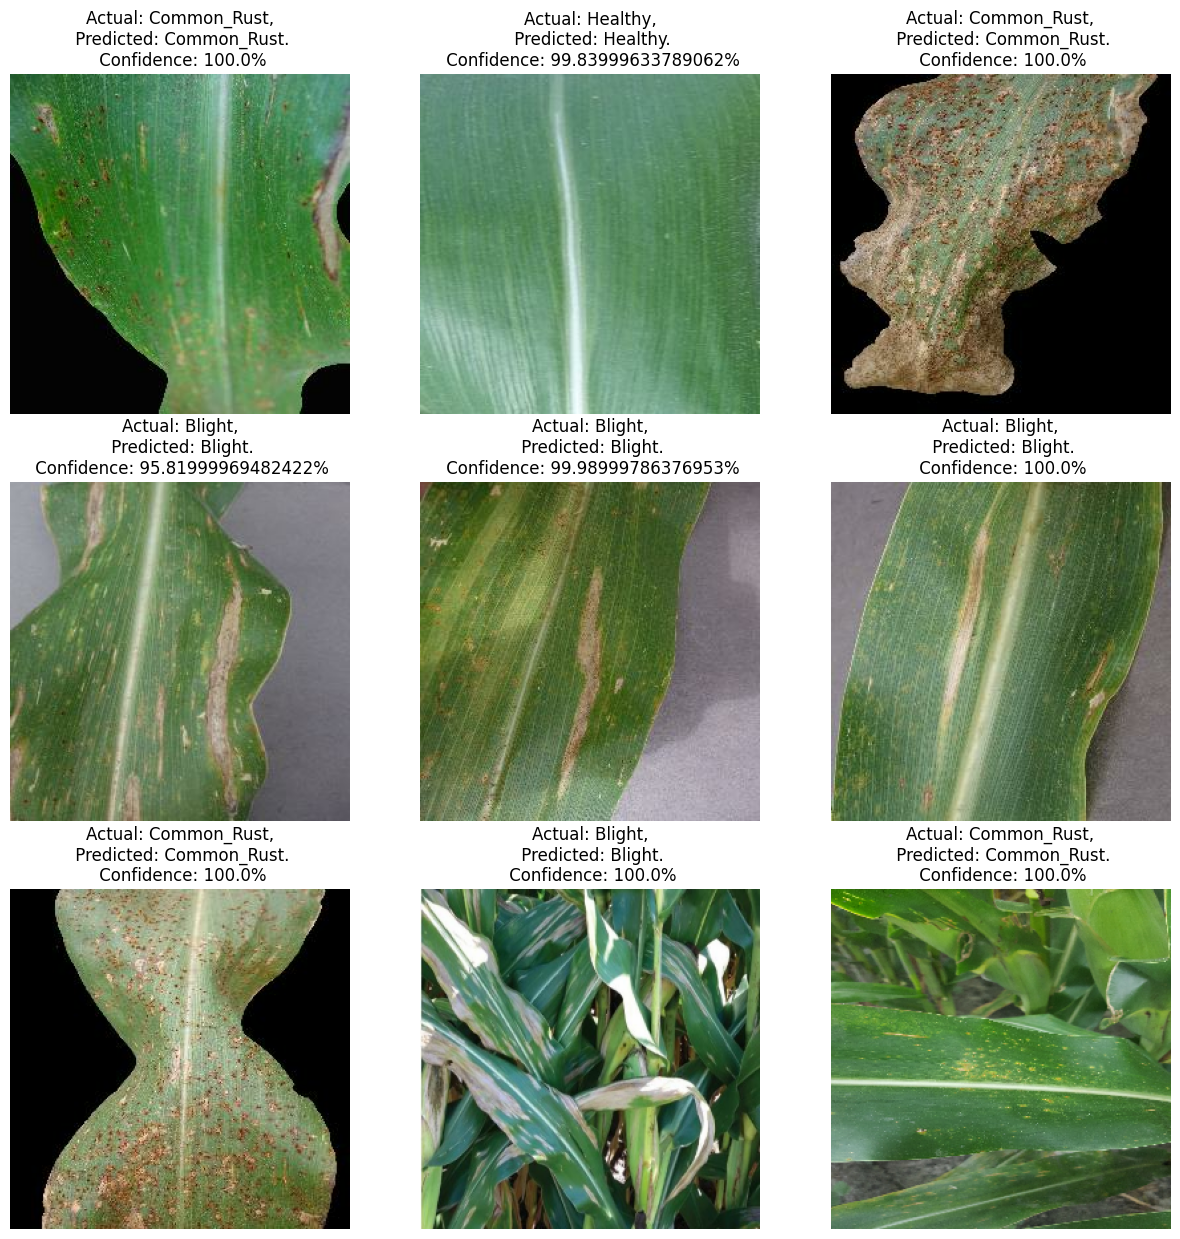

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [51]:
import os

# Define the directory
models_dir = "../models"

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


In [55]:
import os

# Ensure the models directory exists
models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Determine the model version
try:
    model_version = max([int(i.split('.')[0]) for i in os.listdir(models_dir) if i.split('.')[-1] in ['keras', 'h5']] + [0]) + 1
except FileNotFoundError:
    model_version = 1

# Save the model with the `.keras` extension
model.save(f"{models_dir}/{model_version}.keras")


In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite" , "wb") as f : 
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\skcod\AppData\Local\Temp\tmpaaj9xc7s\assets


INFO:tensorflow:Assets written to: C:\Users\skcod\AppData\Local\Temp\tmpaaj9xc7s\assets


Saved artifact at 'C:\Users\skcod\AppData\Local\Temp\tmpaaj9xc7s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2432610168528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2432610169296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2432610168336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2432610170448: TensorSpec(shape=(), dtype=tf.resource, name=None)
